# Survival Prediction - Titanic
---
##### Introduction

The sinking of the Titanic is one of the most infamous shipwrecks in history. On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. That's why the name DieTanic. This is a very unforgetable disaster that no one in the world can forget.

It took about $7.5 million to build the Titanic and it sunk under the ocean due to collision. The Titanic Dataset is a very good dataset for beginners to start a journey in data science and participate in competitions in Kaggle.

The objective of this notebook is to give an idea how is the workflow of any predictive modeling problem. How do we analyze features, how do we add new features, how do we make the existing features useful for the model and some Machine Learning Concepts. I have tried to keep the notebook as basic as possible so that even newbies can understand every phase of it.

We will predict whether a passenger in the Titanic would survive or not based on the passenger's data (name, age, price of ticket, etc). 

The process will be broken down into the following steps:
>1. Exploratory Data Analysis
2. Feature Engineering
3. Define and train the ML models
4. Evaluate the performance of our trained models on the validation set
5. Select the best model and predict the targets for the test set

Before we begin, let's import the necessary libraries and the dataset for working.

In [1]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
from matplotlib import pyplot as plt
import xgboost as xgb
import seaborn as sns
import pandas as pd
import numpy as np
import shap
%matplotlib inline

In [2]:
import warnings
warnings.simplefilter('ignore')

In [3]:
# read csv files from the local disk
train = pd.read_csv('/home/home/Kaggle/titanic/train.csv')
test = pd.read_csv('/home/home/Kaggle/titanic/test.csv')

In [4]:
# number of rows and columns in train and test set
train.shape, test.shape

((891, 12), (418, 11))

In [5]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## Exploratory Data Analysis

### 1. Variable Identification

Identify the types and categories of all the data variables or features. 

In [7]:
#identify numerical and categorical variables
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

We have the following features in the dataset:

**PassengerId** (numerical): &emsp;Id given to each traveler on the ship. (**Target**)

**Pclass** (numerical): &emsp; &emsp; &emsp;The passenger class. 

**Name** (categorical): &emsp; &emsp; &emsp;The Name of the passenger.

**Sex** (categorical): &emsp; &emsp; &emsp; &ensp; Gender of the passenger.

**Age** (numerical): &emsp; &emsp; &emsp; &emsp; Age of the passenger.

**SibSp** (numerical): &emsp; &emsp; &emsp; &nbsp;Number of siblings and spouses traveling with the passenger.

**Parch** (numerical): &emsp; &emsp; &emsp; &nbsp;Number of parents and children traveling with the passenger.

**Ticket** (categorical): &emsp; &emsp; &emsp;The ticket id.

**Fare** (numerical): &emsp; &emsp; &emsp; &emsp;The ticket Fare.

**Cabin** (categorical): &emsp; &emsp; &ensp; &nbsp;The cabin number.

**Embarked** (categorical): &emsp; &nbsp;The embarkation. This describe three possible areas of the Titanic from which the people embark. Three possible values S,C,Q.

From these features, let's identify the meaningful ones and explore them more. Id of the passenger is not a good feature as it doesn't convey any meaning by itself and with other variables to the model. The case of ticket id is also the same. Thus, let's remove the variables 'PassengerId' and 'Ticket' from the dataset and work with the rest. The variable 'Name' by itself is meaningless to the model but we could extract the salutation or title from it to create a new feature 'Title' which indicates the honorifics to address the person. 

In [8]:
train.drop(['PassengerId', 'Ticket'], axis=1, inplace=True)
test.drop(['PassengerId', 'Ticket'], axis=1, inplace=True)

In [9]:
def get_titles(data):
    """ To get the title from each name in the dataset and to add it to a new feature column 'Title.
    
        Args:

            data (dataframe) - Dataset from which we need to get and set the titles in the name.

        Returns:

            data (dataframe) - Dataset after the update is returned.
        
    """
    # extract the title from each name
    data['Title'] = data['Name'].map(lambda name:name.split(',')[1].split('.')[0].strip())
    return data

In [10]:
train = get_titles(train)
test = get_titles(test)

In [11]:
# remove the varibale 'Name' from both the test and train set
train.drop('Name', axis=1, inplace=True)
test.drop('Name', axis=1, inplace=True)

In [12]:
# find unique titles in train
train.Title.unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer'], dtype=object)

In [13]:
# find unique titles in test
test.Title.unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Ms', 'Col', 'Rev', 'Dr', 'Dona'],
      dtype=object)

We can see that there are many titles and many are confusing, so let's categorize them further and we may update it to the feature column 'Title'. Let's define a dictionary to categorize each titles into its respective class.

In [14]:
title_dict = {
    "Capt": "Rare",
    "Col": "Rare",
    "Major": "Rare",
    "Jonkheer": "Rare",
    "Don": "Rare",
    "Dona": "Miss",
    "Sir" : "Rare",
    "Dr": "Rare",
    "Rev": "Rare",
    "the Countess":"Rare",
    "Mme": "Mrs",
    "Mlle": "Miss",
    "Ms": "Mrs",
    "Mr" : "Mr",
    "Mrs" : "Mrs",
    "Miss" : "Miss",
    "Master" : "Master",
    "Lady" : "Rare"
}


In [15]:
# map each title to its class or category
train.Title = train.Title.map(title_dict)
test.Title = test.Title.map(title_dict)

In [16]:
train.Title.unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Rare'], dtype=object)

In [17]:
test.Title.unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Rare'], dtype=object)

### 2. Missing Value Treatment

Missing data in the training dataset can reduce the power / fit of a model or can lead to a biased model as we don't know its behavior and relationship with other variables correctly. It can also lead to wrong prediction or classification.

Let's analyze the missing values in our dataset.

In [18]:
train.isna().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Cabin       687
Embarked      2
Title         0
dtype: int64

In [19]:
test.isna().sum()

Pclass        0
Sex           0
Age          86
SibSp         0
Parch         0
Fare          1
Cabin       327
Embarked      0
Title         0
dtype: int64

We can see that there are 177 missing values in the variable 'Age', 687 in the variable 'Cabin' and 2 in the variable 'Embarked'.

Let's drop the variable 'Cabin' as 77% of the variable's data is missing. Since the variable 'Embarked' has only two missing values, we may impute it with the most frequent label in the variable (i.e. 'S'). And in the case of the variable 'Age', just by replacing the same with the mean/median age might not be the best solution, since the age may differ by group and categories of passengers. Hence, we can impute values based on the median of age while the variables are grouped by 'Sex', 'Pclass', and 'Title'.

In [20]:
train.drop(['Cabin'], axis=1, inplace=True)
test.drop(['Cabin'], axis=1, inplace=True)

In [21]:
# groupby and find the median of age for train
grouped_median_train = train.groupby(['Sex','Pclass','Title']).median()
grouped_median_train = grouped_median_train.reset_index()[['Sex', 'Pclass', 'Title', 'Age']]

In [22]:
grouped_median_train.head()

,Sex,Pclass,Title,Age
0,female,1,Miss,30.0
1,female,1,Mrs,40.0
2,female,1,Rare,48.0
3,female,2,Miss,24.0
4,female,2,Mrs,31.5


In [23]:
def fill_age(row):
    """ To assign value for the missing values of based on the group.

            If a title is missing then the age will be assigned based on sex and class.
            
        Args: 
            
            row (dataframe) - A row in the dataframe.
        
        Returns:
        
            The values of the computed age in the dataframe.
    """
    condition = (
        (grouped_median_train['Sex'] == row['Sex']) & 
        (grouped_median_train['Title'] == row['Title']) & 
        (grouped_median_train['Pclass'] == row['Pclass'])
    ) 
    if np.isnan(grouped_median_train[condition]['Age'].values[0]):
        print('true')
        condition = (
            (grouped_median_train['Sex'] == row['Sex']) & 
            (grouped_median_train['Pclass'] == row['Pclass'])
        )

    return grouped_median_train[condition]['Age'].values[0]


def process_age(data):
    """ To fill the missing values of the Age variable
        
        Args:
        
            data (dataframe) - The dataset into which we need to fill the missing values of the age.
            
        Returns:
        
            data (dataframe) - Processed dataset
    """
    data.Age = data.apply(lambda row: fill_age(row) if np.isnan(row['Age']) else row['Age'], axis=1)
    return data

In [24]:
# replace missing values of Embarked in train with its most frequent data
train.Embarked.fillna('S', inplace=True)
# fill the missing values of age in train with the median age of the group
train = process_age(train)
test = process_age(test)
# assign mean of the variable Fare in test to the missing value of fare 
test.Fare = test['Fare'].fillna(train['Fare'].median())
# to convert the variable Age to dataframe which is currently series 
train = pd.DataFrame(train)
test = pd.DataFrame(test)

In [25]:
train.isna().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
Title       0
dtype: int64

In [26]:
test.isna().sum()

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
Title       0
dtype: int64

In [27]:
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,male,22.0,1,0,7.2500,S,Mr
1,1,1,female,38.0,1,0,71.2833,C,Mrs
2,1,3,female,26.0,0,0,7.9250,S,Miss
3,1,1,female,35.0,1,0,53.1000,S,Mrs
4,0,3,male,35.0,0,0,8.0500,S,Mr


In [28]:
test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,3,male,34.5,0,0,7.8292,Q,Mr
1,3,female,47.0,1,0,7.0000,S,Mrs
2,2,male,62.0,0,0,9.6875,Q,Mr
3,3,male,27.0,0,0,8.6625,S,Mr
4,3,female,22.0,1,1,12.2875,S,Mrs


### 3. Univariate Analysis

At this stage, we explore variables one by one. Method to perform uni-variate analysis will depend on whether the variable type is categorical or continuous.

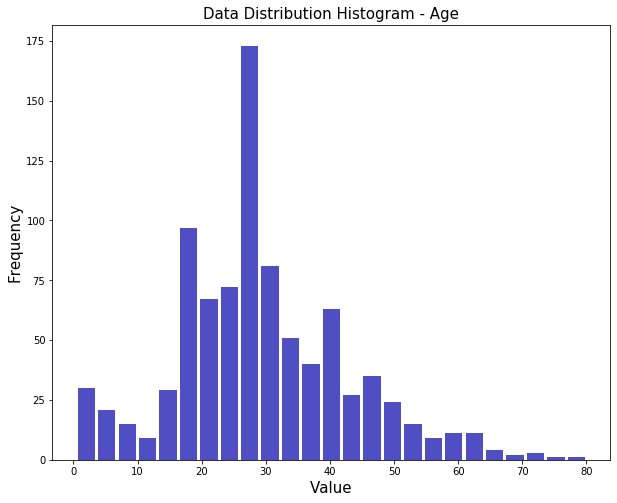

In [29]:
plt.figure(figsize=[10, 8])
plt.hist(x=train.Age, bins='auto', color='#0504aa',alpha=0.7, rwidth=0.85)
plt.xlabel('Value',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.title('Data Distribution Histogram - Age',fontsize=15)
plt.show()

From the figure we can understand that the data distribution of Age is positively skewed or right skewed. So in skewed data, the tail region may act as an outlier for the statistical model and we know that outliers adversely affect the model’s performance. As tree based models are not effected by skewness or outliers we may not normalize the data for the same. But, other linear or non-linear models will be effected by the skewness or outliers and hence, we may need to normalize the data afterwards.

And also, we can infer from the figure that most of the passengers were aged between 18 and 35. 

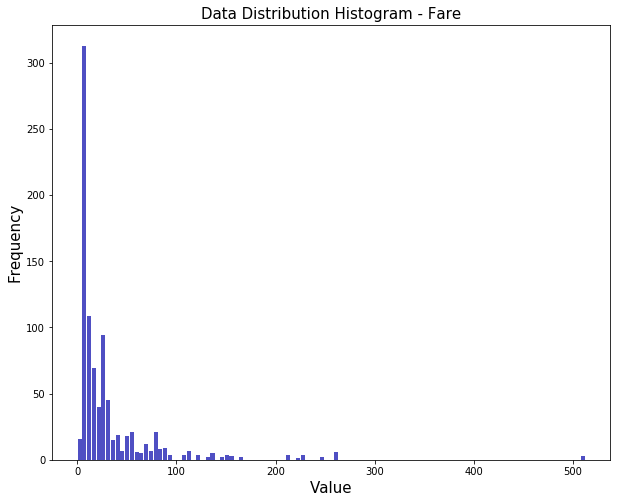

In [30]:
plt.figure(figsize=[10, 8])
plt.hist(x=train.Fare, bins='auto', color='#0504aa',alpha=0.7, rwidth=0.85)
plt.xlabel('Value',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.title('Data Distribution Histogram - Fare',fontsize=15)
plt.show()

Most of the people paid between 5 to 25 units.

In [31]:
# find frequency of each label in the variable
Pclass_counts = train.Pclass.value_counts()
Sex_counts = train.Sex.value_counts()
SibSp_counts = train.SibSp.value_counts()
Parch_counts = train.Parch.value_counts()
Embarked_counts = train.Embarked.value_counts()
Title_counts = train.Title.value_counts()
Survived_counts = train.Survived.value_counts()

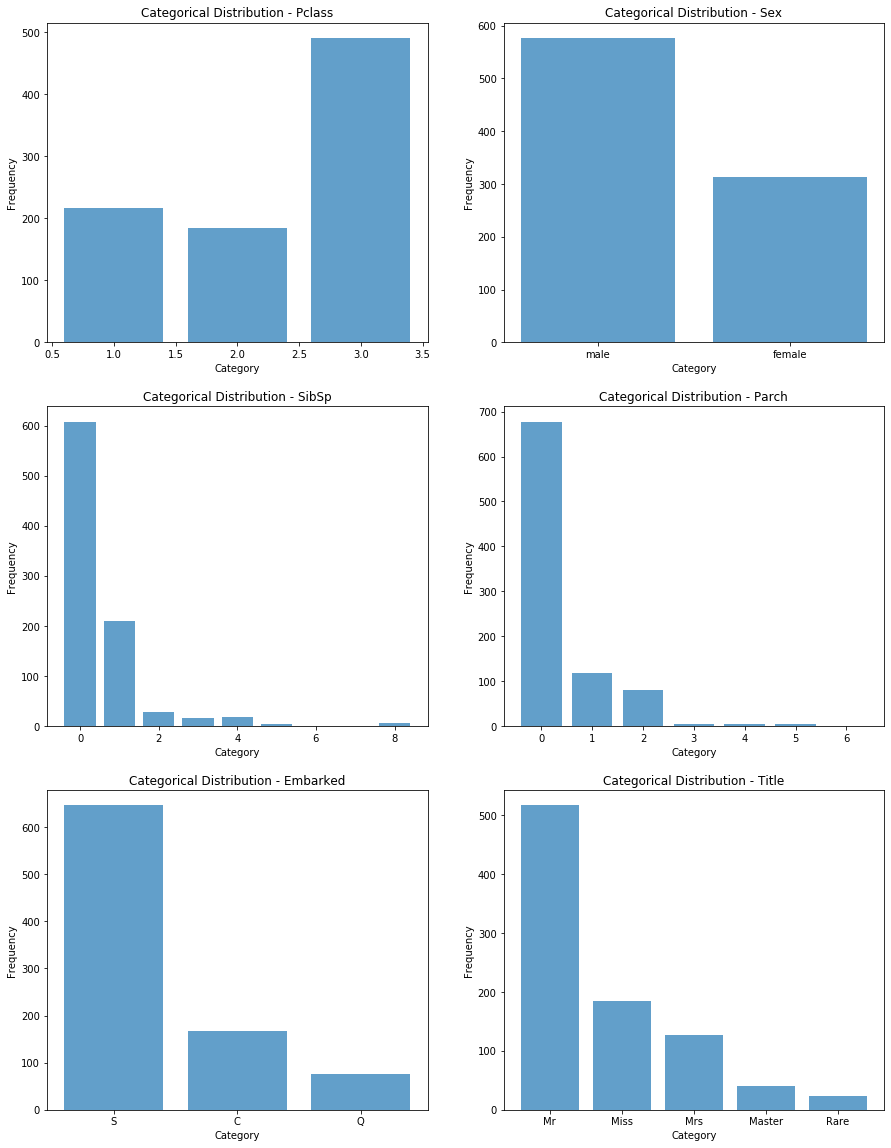

In [32]:
fig, axs = plt.subplots(3, 2, figsize=[15, 20])

axs[0,0].bar(Pclass_counts.index, Pclass_counts, alpha=0.7)
axs[0,0].set_title('Categorical Distribution - Pclass')

axs[0,1].bar(Sex_counts.index, Sex_counts,alpha=0.7)
axs[0,1].set_title('Categorical Distribution - Sex')

axs[1,0].bar(SibSp_counts.index, SibSp_counts,alpha=0.7)
axs[1,0].set_title('Categorical Distribution - SibSp')

axs[1,1].bar(Parch_counts.index, Parch_counts,alpha=0.7)
axs[1,1].set_title('Categorical Distribution - Parch')

axs[2,0].bar(Embarked_counts.index, Embarked_counts,alpha=0.7)
axs[2,0].set_title('Categorical Distribution - Embarked')

axs[2,1].bar(Title_counts.index, Title_counts,alpha=0.7)
axs[2,1].set_title('Categorical Distribution - Title')

for ax in axs.flat:
    ax.set(xlabel='Category', ylabel='Frequency')

Most of the people were in the class 3 (almost double of class 1 and 2.). The number of male passengers were almost double of female passengers. From the frequency graph of SibSp and Parch we can understand that most of the passengers were alone. People embarked from 'S' is really high. People who are addressed with the honorific 'Mr' is the highest.  

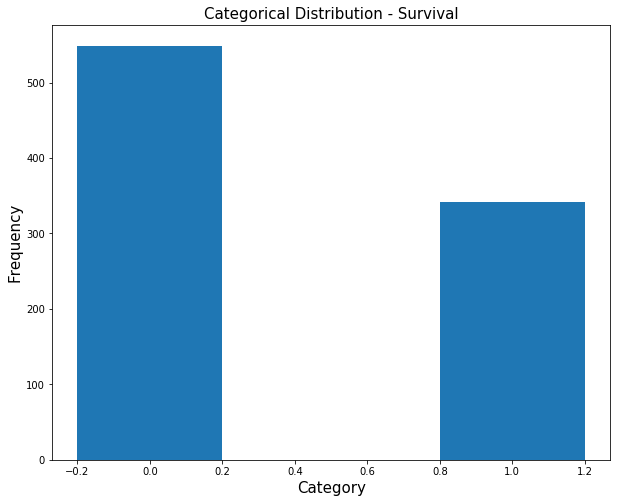

In [33]:
plt.figure(figsize=[10, 8])
p = plt.bar(Survived_counts.index, Survived_counts, width=.4)
plt.xlabel('Category',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.title('Categorical Distribution - Survival',fontsize=15)
plt.show()

From the figure it is clear that the dataset is imbalanced. We are having the data of non-survived people than the survived people. Sometimes it could influence our predictions.

### Bivariate Analysis

In this stage, we will find out the relationship between two variables. In other words, we look for association and disassociation between variables at a predefined significance level. We can perform bivariate analysis for any combination of categorical and continuous variables.

In [34]:
data = train[['Survived', 'Sex']]
data['Died'] = 1 - data['Survived']

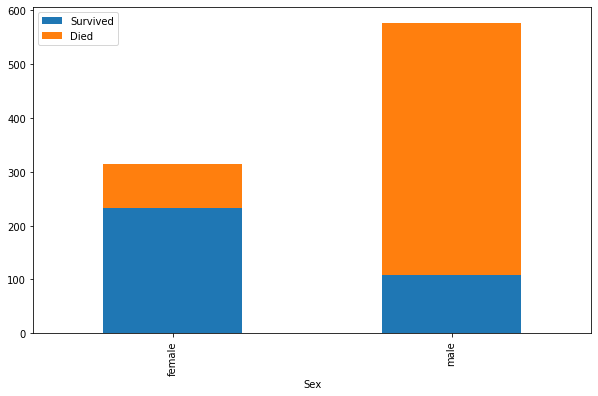

In [35]:
data.groupby('Sex').agg('sum')[['Survived','Died']].plot(kind='bar',stacked=True, figsize=[10, 6])

From the chart we can infer that most of the male passengers are died compared to females. Let's explore this chart more to find out whether the died female or male passenger has any correlation with their Status, Title and Age.

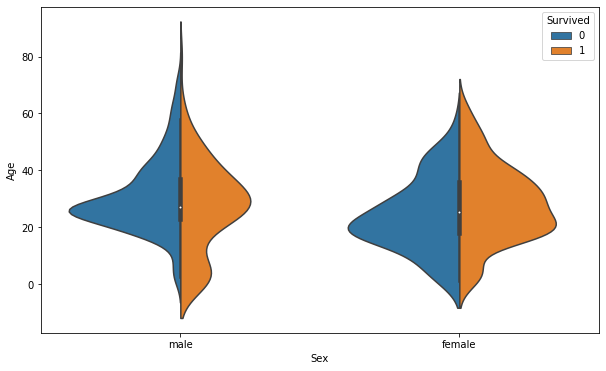

In [36]:
plt.figure(figsize=[10, 6])
sns.violinplot(x='Sex', y='Age', hue='Survived', data=train, split=True)

Most of the male passengers in the age 20 to 30 were died but most of the survived male were in the age 25 to 35. In the case of female passengers, most of them have survived but the age of the most people died were in their 20's.

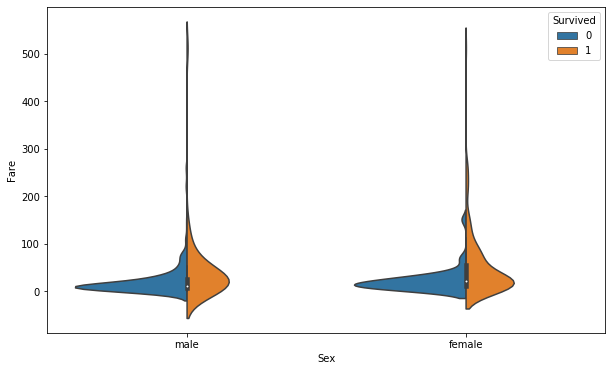

In [37]:
plt.figure(figsize=[10, 6])
sns.violinplot(x='Sex', y='Fare', hue='Survived', data=train, split=True)

People who have paid the lowest fare has the highest highest death rate. 

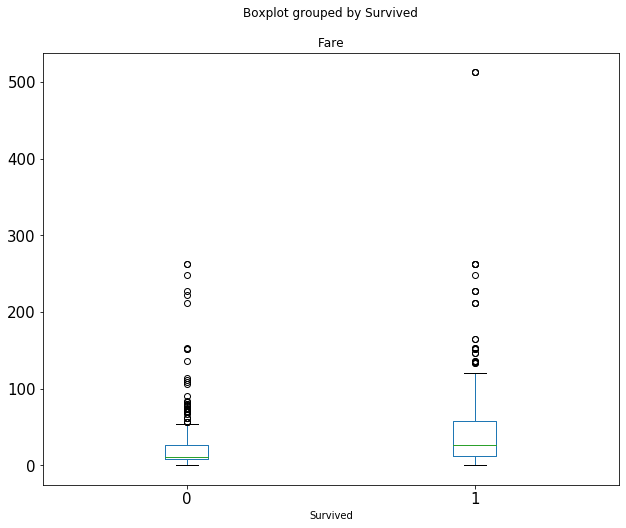

In [38]:
fig, ax = plt.subplots(figsize=[10, 8])
train.boxplot(column='Fare', by='Survived', ax=ax, grid=False, fontsize=15)

We can observe that there are some outliers in the variable Fare. The passenger record with Fare between 200 and 300 can be considered as outliers as it exist in both the survival and non-survival. Whereas, the outliers in survival with the Fare greater than 500 indicates some meaning to the model that the people who paid high is survived.

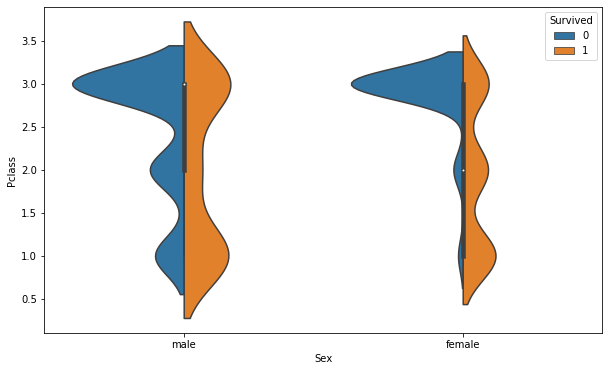

In [39]:
plt.figure(figsize=[10, 6])
sns.violinplot(x='Sex', y='Pclass', hue='Survived', data=train, split=True)

Both male and female passengers in class 3 had died the most.

In [40]:
data['Title'] = train['Title']

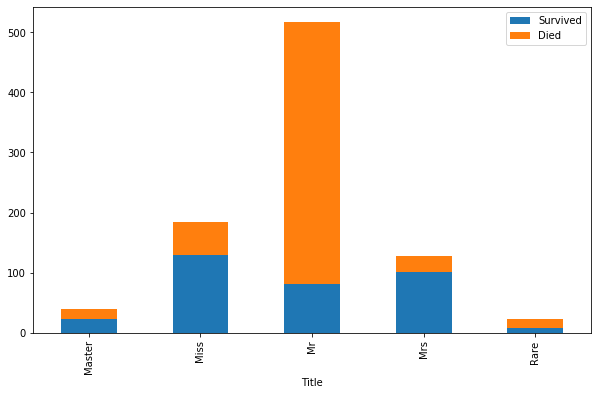

In [41]:
data.groupby('Title').agg('sum')[['Survived','Died']].plot(kind='bar',stacked=True, figsize=[10, 6])

Boys and women are the most survived people relative to their respective class population.

### Feature Engineering

In Feature Engineering we are not going to add any new data, but we are going to make the data that we already have useful.

Since we are going to use tree based ensemble methods, we don't need to standardize or normalize the data. 

In [42]:
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,male,22.0,1,0,7.2500,S,Mr
1,1,1,female,38.0,1,0,71.2833,C,Mrs
2,1,3,female,26.0,0,0,7.9250,S,Miss
3,1,1,female,35.0,1,0,53.1000,S,Mrs
4,0,3,male,35.0,0,0,8.0500,S,Mr


In [43]:
test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,3,male,34.5,0,0,7.8292,Q,Mr
1,3,female,47.0,1,0,7.0000,S,Mrs
2,2,male,62.0,0,0,9.6875,Q,Mr
3,3,male,27.0,0,0,8.6625,S,Mr
4,3,female,22.0,1,1,12.2875,S,Mrs


In [44]:
def process_family(data):
    # the size of families (including the passenger)
    data['FamilySize'] = data['Parch'] + data['SibSp'] + 1 
    return data

In [45]:
train = process_family(train)
test = process_family(test)

In [46]:
sex_map = {
    'male' : 0,
    'female' : 1
}

embarked_map = {
    'Q' : 0,
    'S' : 1,
    'C' : 2
}

title_map = {
             "Mr": 1, 
             "Master": 2, 
             "Mrs": 3, 
             "Miss": 4, 
             "Rare": 5
            }

In [47]:
# label encode the categorical variables
train.Sex = train.Sex.map(sex_map)
test.Sex = test.Sex.map(sex_map)
train.Embarked = train.Embarked.map(embarked_map)
test.Embarked = test.Embarked.map(embarked_map)
train.Title = train.Title.map(title_map)
test.Title = test.Title.map(title_map)

In [48]:
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,FamilySize
0,0,3,0,22.0,1,0,7.2500,1,1,2
1,1,1,1,38.0,1,0,71.2833,2,3,2
2,1,3,1,26.0,0,0,7.9250,1,4,1
3,1,1,1,35.0,1,0,53.1000,1,3,2
4,0,3,0,35.0,0,0,8.0500,1,1,1


In [49]:
test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,FamilySize
0,3,0,34.5,0,0,7.8292,0,1,1
1,3,1,47.0,1,0,7.0000,1,3,2
2,2,0,62.0,0,0,9.6875,0,1,1
3,3,0,27.0,0,0,8.6625,1,1,1
4,3,1,22.0,1,1,12.2875,1,3,3


In [50]:
# drop the variable 'SibSp' as we have already created a similar variable FamilySize
train = train.drop(['SibSp'], axis = 1)
test  = test.drop(['SibSp'], axis = 1)

In [51]:
# seperate the feature set and the target set
X_train = train.loc[:, train.columns!='Survived']
y_train = train['Survived']
X_test = test

In [52]:
#split the train data into train and valid set
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.10, random_state=111)

In [53]:
X_train.shape, X_valid.shape

((801, 8), (90, 8))

### Define and train the ML algorithm

We will try the tree based ensemble methods Random Forest, XGBoost and the linear model Logistic Regressor for creating the model and may choose the best model. And, may evaluate each model using the KFold cross-validation method.

### Random Forest

In [54]:
model = RandomForestClassifier(n_estimators=150, min_samples_leaf=3, max_features=0.5, n_jobs=-1)
model.fit(X_train, y_train)
model.score(X_train, y_train)

0.9088639200998752

In [55]:
train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, train_sizes=np.linspace(0.01, 1.0, 10), scoring='accuracy')

# Create means of training set scores
train_mean = np.mean(train_scores, axis=1)

# Create means of test set scores
test_mean = np.mean(test_scores, axis=1)

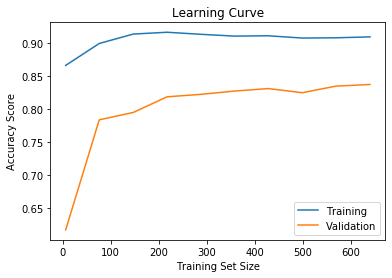

In [56]:
# Create plot
plt.plot(train_sizes, train_mean, label="Training")
plt.plot(train_sizes, test_mean, label="Validation")
plt.title("Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy Score")
plt.legend()
plt.show()

In [57]:
predict = model.predict(X_valid)
accuracy_score(y_valid, predict)

0.8222222222222222

In [58]:
print(classification_report(y_valid, predict))

              precision    recall  f1-score   support

           0       0.83      0.89      0.86        55
           1       0.81      0.71      0.76        35

    accuracy                           0.82        90
   macro avg       0.82      0.80      0.81        90
weighted avg       0.82      0.82      0.82        90



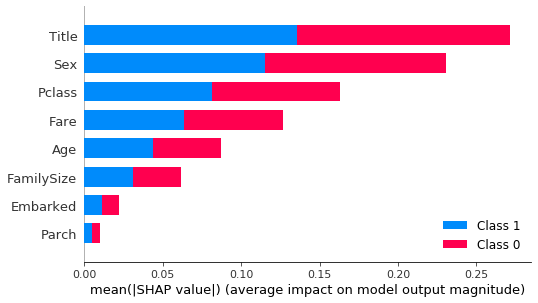

In [59]:
# find the variable or feature importance
shap_values = shap.TreeExplainer(model).shap_values(X_train)
shap.summary_plot(shap_values, X_train)

#### K-Fold

Cross-validation is primarily used in applied machine learning to estimate the skill of a machine learning model on unseen data. That is, to use a limited sample in order to estimate how the model is expected to perform in general when used to make predictions on data not used during the training of the model. 

We may use the K-Fold cross-validation method to test the effectiveness of our Random Forest model. I have set the parameter ‘K’ to 10 i.e. we may split the dataset into 10 parts or folds. Each time on the loop we may consider a single fold for testing and rest for training, non-repeatedly. We may evaluate the model on accuracy each time on the respective test set and all the scores are averaged to obtain a more comprehensive model validation score.

In [60]:
# Desired number of Cross Validation folds
cv = KFold(n_splits=10)            
accuracies = list()
max_attributes = len(list(test))
depth_range = range(1, max_attributes + 1)

# Testing max_depths from 1 to max attributes
# Uncomment prints for details about each Cross Validation pass
for depth in depth_range:
    fold_accuracy = []
    tree_model = RandomForestClassifier(n_estimators=150, min_samples_leaf=3, max_features=0.5, n_jobs=-1, max_depth=depth)
    # print("Current max depth: ", depth, "\n")
    for train_fold, valid_fold in cv.split(train):
        f_train = train.loc[train_fold] # Extract train data with cv indices
        f_valid = train.loc[valid_fold] # Extract valid data with cv indices

        model = tree_model.fit(X = f_train.drop(['Survived'], axis=1), 
                               y = f_train["Survived"]) # We fit the model with the fold train data
        valid_acc = model.score(X = f_valid.drop(['Survived'], axis=1), 
                                y = f_valid["Survived"])# We calculate accuracy with the fold validation data
        fold_accuracy.append(valid_acc)

    avg = sum(fold_accuracy)/len(fold_accuracy)
    accuracies.append(avg)
    # print("Accuracy per fold: ", fold_accuracy, "\n")
    # print("Average accuracy: ", avg)
    # print("\n")
    
# Just to show results conveniently
df = pd.DataFrame({"Max Depth": depth_range, "Average Accuracy": accuracies})
df = df[["Max Depth", "Average Accuracy"]]
print(df.to_string(index=False))

 Max Depth  Average Accuracy
         1          0.786729
         2          0.817066
         3          0.831660
         4          0.829401
         5          0.833908
         6          0.839538
         7          0.836180
         8          0.841773


In [61]:
print(np.mean(accuracies))

0.8270318352059924


### XGBoost

In [63]:
params = {

    'max_depth' : 5,
    'n_estimators': 15,
    'gamma': 6,
    'objective' : 'binary:logistic',
    'eval_metric' : ["error", "logloss"],
    'n_gpus' : 0
}

In [64]:
model = xgb.XGBClassifier(**params)

In [65]:
evallist = [(X_train, y_train), (X_valid, y_valid)]

In [66]:
model.fit(X_train, y_train, eval_set=evallist, eval_metric=["error", "logloss"], verbose=False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1,
              eval_metric=['error', 'logloss'], gamma=6, learning_rate=0.1,
              max_delta_step=0, max_depth=5, min_child_weight=1, missing=None,
              n_estimators=15, n_gpus=0, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=1, verbosity=1)

In [67]:
predictions = model.predict(X_valid)

In [68]:
print(classification_report(y_valid, predictions))

              precision    recall  f1-score   support

           0       0.81      0.95      0.87        55
           1       0.88      0.66      0.75        35

    accuracy                           0.83        90
   macro avg       0.85      0.80      0.81        90
weighted avg       0.84      0.83      0.83        90



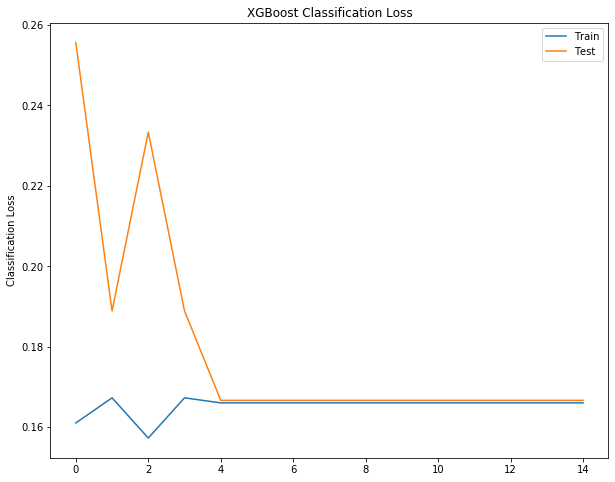

In [69]:
# retrieve performance metrics
results = model.evals_result_
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
fig, ax = plt.subplots(figsize=(10,8))
plt.plot(x_axis, results['validation_0']['error'], label = 'Train')
plt.plot(x_axis, results['validation_1']['error'], label = 'Test')
ax.legend()
plt.ylabel('Classification Loss')
plt.title('XGBoost Classification Loss')
plt.show()

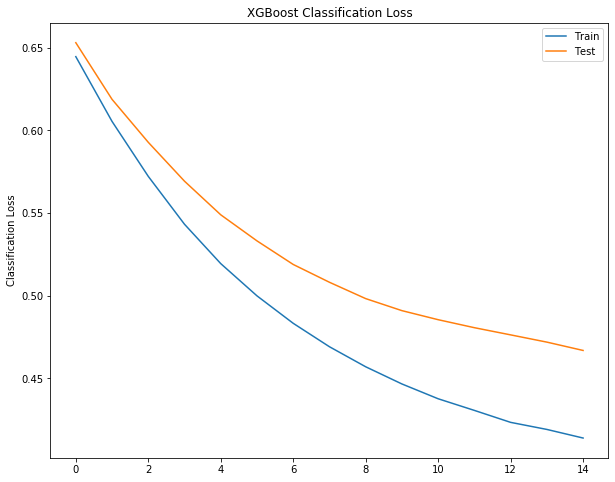

In [70]:
# retrieve performance metrics
results = model.evals_result_
epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)
fig, ax = plt.subplots(figsize=(10,8))
plt.plot(x_axis, results['validation_0']['logloss'], label = 'Train')
plt.plot(x_axis, results['validation_1']['logloss'], label = 'Test')
ax.legend()
plt.ylabel('Classification Loss')
plt.title('XGBoost Classification Loss')
plt.show()

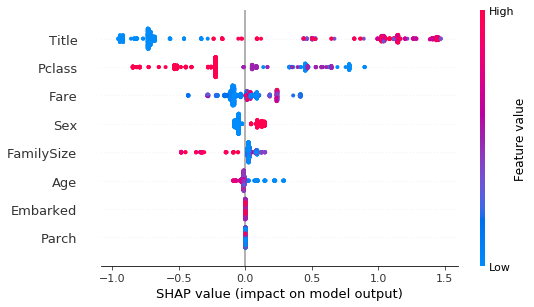

In [71]:
# find the variable or feature importance
shap_values = shap.TreeExplainer(model).shap_values(X_train)
shap.summary_plot(shap_values, X_train)

#### K-Fold

We may use the K-Fold cross-validation method to test the effectiveness of our XGBoost model. I have set the parameter ‘K’ to 10 i.e. we may split the dataset into 10 parts or folds. Each time on the loop we may consider a single fold for testing and rest for training, non-repeatedly. We may evaluate the model on accuracy each time on the respective test set and all the scores are averaged to obtain a more comprehensive model validation score.

In [72]:
params = {

    'n_estimators': 15,
    'gamma': 6,
    'objective' : 'binary:logistic',
    'eval_metric' : ["error", "logloss"],
    'n_gpus' : 0
}

In [73]:
# Desired number of Cross Validation folds
cv = KFold(n_splits=10)            
accuracies = list()
max_attributes = len(list(test))
depth_range = range(1, max_attributes + 1)

# Testing max_depths from 1 to max attributes
# Uncomment prints for details about each Cross Validation pass
for depth in depth_range:
    fold_accuracy = []
    tree_model = xgb.XGBClassifier(**params, max_depth=depth)
    # print("Current max depth: ", depth, "\n")
    for train_fold, valid_fold in cv.split(train):
        f_train = train.loc[train_fold] # Extract train data with cv indices
        f_valid = train.loc[valid_fold] # Extract valid data with cv indices

        model = tree_model.fit(X = f_train.drop(['Survived'], axis=1), 
                               y = f_train["Survived"]) # We fit the model with the fold train data
        valid_acc = model.score(X = f_valid.drop(['Survived'], axis=1), 
                                y = f_valid["Survived"])# We calculate accuracy with the fold validation data
        fold_accuracy.append(valid_acc)

    avg = sum(fold_accuracy)/len(fold_accuracy)
    accuracies.append(avg)
    # print("Accuracy per fold: ", fold_accuracy, "\n")
    # print("Average accuracy: ", avg)
    # print("\n")
    
# Just to show results conveniently
df = pd.DataFrame({"Max Depth": depth_range, "Average Accuracy": accuracies})
df = df[["Max Depth", "Average Accuracy"]]
print(df.to_string(index=False))

 Max Depth  Average Accuracy
         1          0.787853
         2          0.823795
         3          0.829401
         4          0.828277
         5          0.827154
         6          0.826055
         7          0.823808
         8          0.823808


In [74]:
print(np.mean(accuracies))

0.8212687265917602


### Logistic Regression

In [75]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [76]:
numerical_columns = ['Age', 'Fare']

In [77]:
scaler = StandardScaler()
train[numerical_columns] = scaler.fit_transform(train[numerical_columns])
test[numerical_columns] = scaler.fit_transform(test[numerical_columns])

In [78]:
X_train = train.loc[:, train.columns!='Survived']
y_train = train['Survived']
X_test = test
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.10)

In [79]:
# Instantiate our model
logreg = LogisticRegression()
# Fit our model to the training data
logreg.fit(X_train, y_train)
# Predict on the test data
logreg_predictions = logreg.predict(X_valid)
print(classification_report(y_valid, logreg_predictions))

              precision    recall  f1-score   support

           0       0.85      0.80      0.82        59
           1       0.66      0.74      0.70        31

    accuracy                           0.78        90
   macro avg       0.76      0.77      0.76        90
weighted avg       0.79      0.78      0.78        90



#### K-Fold

We may use the K-Fold cross-validation method to test the effectiveness of our Linear Regression model. I have set the parameter ‘K’ to 10 i.e. we may split the dataset into 10 parts or folds. Each time on the loop we may consider a single fold for testing and rest for training, non-repeatedly. We may evaluate the model on accuracy each time on the respective test set and all the scores are averaged to obtain a more comprehensive model validation score.

In [82]:
model=LogisticRegression()
predicted = cross_val_predict(model, X_train, y_train, cv=10)
print(classification_report(y_train, predicted) )
print(accuracy_score(y_train, predicted))

              precision    recall  f1-score   support

           0       0.82      0.88      0.85       490
           1       0.78      0.70      0.74       311

    accuracy                           0.81       801
   macro avg       0.80      0.79      0.80       801
weighted avg       0.81      0.81      0.81       801

0.8102372034956304


#### Saving the Model

We can see that Random Forest model has performed well for the train and validation set. Thus, hoping it would also perform well for the test set, we may execute the model again and then run the following code to create the prediction file at your local directory. File is saved in the format suitable for submission in the Kaggle:Titanic challenge.

In [ ]:
output = model.predict(X_test)

In [ ]:
test_set = pd.read_csv('/home/home/Kaggle/titanic/test.csv')
output_csv = pd.DataFrame()
output_csv['PassengerId'] = test_set['PassengerId']
output_csv['Survived'] = output
output_csv[['PassengerId','Survived']].to_csv('/home/home/Kaggle/titanic/output_two.csv', index=False)